# HSE-2024 text classification project

## Table of content
* [Imports](#c1)
* [Data loading and preprocessing](#c2)
* [Custom dataset](#c3)
* [Custom model](#c4)
* [Trainer](#c5)
* [Model training](#c6)

### Imports <a class="anchor" id="c1"></a>

In [2]:
import numpy as np
import pandas as pd

import torch
from sklearn.model_selection import train_test_split

import os
import re
import string

from classes import Preprocessor, MyModel, Trainer

RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)

### Data loading and preprocessing <a class="anchor" id="c2"></a>

In [6]:
base_dir = 'data/'
texts = pd.read_csv(f'{base_dir}texts_and_metadata.txt', sep='\t')
data = pd.read_csv(f'{base_dir}coding_results.txt', low_memory=False, sep='\t')
df = texts.merge(data, how='left')

df.drop(df[df['do_text_make_sense_raw'] == 'no'].index, inplace=True)

ops = ['is_text_positive_recoded', 'is_text_neg_recoded']
df[ops] = df[ops].apply(pd.to_numeric, errors='coerce')
pos_ = df['is_text_positive_recoded']
neg_ = df['is_text_neg_recoded']
df.loc[(pos_ > 0) & (neg_ < 0), ops] = None
df.loc[neg_ < 0, 'text_sentiment'] = -1
df.loc[pos_ > 0, 'text_sentiment'] = 1
df.loc[(neg_ == 0) & (pos_ == 0), 'text_sentiment'] = 0

df = df.fillna(np.nan).replace([np.nan], [None])

In [7]:
args = ['text_sentiment', 'has_eth_conflict_raw', 'has_pos_eth_interaction_raw', 'opinion_about_ethnonym_recoded',
        'is_ethicity_superior_meaning', 'is_ethicity_aggressor_meaning',
        'is_ethicity_dangerous_meaning']
MAX_SPOIL = len(args)
topic_to_russian = {'culture': 'культура', 'economics': 'экономика', 'ethicity': 'этничность', 'history': 'история',
                    'humour': 'юмор', 'daily_routine': 'рутина', 'migration': 'миграция', 'other': 'другая',
                    'politics': 'политика', 'religion': 'религия', 'society_social': 'социальная'}

var_vocab = {
    'text_sentiment': {'labels': {-1.0: 'этот текст является негативным', 0: 'этот текст является нейтральным',
                                  1.0: 'этот текст является позитивным'}, 'aspect_level': False, 'prompt': 'тональность текста'},
    'has_eth_conflict_raw': {
        'labels': {'yes': 'в тексте есть этнический конфликт', 'no': 'в тексте этнический конфликт отсутствует',
                   'unk': None},
        'aspect_level': False, 'prompt': 'оцени наличие этнического конфликта'},
    'has_pos_eth_interaction_raw': {'labels': {'yes': 'в тексте есть позитивное взаимодействие между этичностями',
                                               'no': 'в тексте не зафиксировано позитивного взаимодействия этичностей',
                                               'unk': None},
                                    'aspect_level': False, 'prompt': 'наличие позитивного взаимодействия этничностей'},
    'opinion_about_ethnonym_recoded': {'labels': {-1: 'мнение об этничности \'{}\' отрицательное',
                                                  0: 'мнение об этничности \'{}\' нейтральное или не зафиксировано',
                                                  1: 'мнение об этничности \'{}\' положительное'},
                                       'aspect_level': True, 'prompt': 'мнение о {} в тексте'},
    # 'represent_ethicity_meaning': {'labels': {}, 'aspect_level': True}, # not using yet
    'is_ethicity_superior_meaning': {'labels': {'high': 'этничность \'{}\' является доминирующей',
                                                'low': 'этничность \'{}\' является отчасти доминирующей',
                                                'irrel': None},
                                     'aspect_level': True, 'prompt': 'является ли этничность {} доминирующей'},
    'is_ethicity_aggressor_meaning': {'labels': {'agressor':
                                                     'этничность \'{}\' является агрессором',
                                                 'victim': 'этничность \'{}\' является жертвой',
                                                 'irrel': None},
                                      'aspect_level': True, 'prompt': 'является ли этничность {} агрессором'},
    'is_ethicity_dangerous_meaning': {
        'labels': {'yes': 'этничность \'{}\' является опасной',
                   'no': 'этничность \'{}\' не является опасной',
                   'irrel': None},
        'aspect_level': True, 'prompt': 'является ли этничность {} опасной'},
}

In [8]:
def clean(text):
    text = text.apply(lambda x: str(x))
    CLEANR = [re.compile('<.*?>'), re.compile("\[.*?\]")]
    for i in CLEANR:
        text = text.apply(lambda x: re.sub(i, '', x))
    text = text.apply(lambda x: x.replace('\\', ''))
    text = text.apply(lambda x: re.sub(r"([" + re.escape(string.punctuation) + r"])\1+", r"\1", x))
    text = text.apply(lambda x: re.sub(r"http\S+", '', x))
    text = text.apply(lambda x: re.sub(r"\r", '', x))
    text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
    text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
    text = text.apply(lambda x: re.sub('"+','"', x))
    text = text.apply(lambda x: re.sub("'+","'", x))
    items = string.punctuation + " "
    text = text.apply(lambda x: x.lstrip(items) if isinstance(x, str) else x)
    return text

<>:3: SyntaxWarning: invalid escape sequence '\['
<>:3: SyntaxWarning: invalid escape sequence '\['
C:\Users\toxas\AppData\Local\Temp\ipykernel_5484\3087058704.py:3: SyntaxWarning: invalid escape sequence '\['
  CLEANR = [re.compile('<.*?>'), re.compile("\[.*?\]")]


In [9]:
df['source_text'] = clean(df['source_text'])

### Custom dataset <a class="anchor" id="c3"></a>

In [13]:
ids = df['document.id'].unique()
process_ids, test_ids = train_test_split(ids, test_size=0.2, random_state=RANDOM_STATE)
train_ids, validate_ids = train_test_split(process_ids, train_size=0.75, random_state=RANDOM_STATE)

train = df.loc[df['document.id'].isin(train_ids)]
test = df.loc[df['document.id'].isin(test_ids)]
validate = df.loc[df['document.id'].isin(validate_ids)]
train.shape, test.shape, validate.shape  # percents are ≈ (60%, 20%, 20%)

preprocessor = Preprocessor.Preprocessor(df=df, args=args, var_vocab=var_vocab, topic_to_russian=topic_to_russian)

((47999, 62), (16170, 62), (16281, 62))

### Trainer <a class="anchor" id="c5"></a>

In [15]:
params = {
    'batch_size': [8, 16, 32, 64],
    'lr': [1e-5, 1e-6, 1e-4],
    'max_spoil': range(1, MAX_SPOIL + 1, 1),
    'spoil_proba': np.arange(0.1,  1, 0.1)
}

In [28]:
trainer = Trainer.Trainer(MyModel.MyModel, train, validate, test, device='cuda', preprocessor=preprocessor, params=params)

### Bert model training <a class="anchor" id="c6"></a>

In [30]:
trainer.choose_model() # uncomment if you want to find best model
trainer.save()

### Генерация описаний

In [1]:
from gpt_classes import GPTDataset, GPTModel, GPTTrainer

c:\Users\toxas\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
gptTrainer = GPTTrainer.GPTTrainer(GPTModel.GPTModel, device, train, validate, test, preprocessor=preprocessor, dataset=GPTDataset.GPTDataset, args=var_vocab, dataloader=DataLoader)
# gptTrainer = GPTTrainer.GPTTrainer(GPTModel.GPTModel, device, train, validate, test, preprocessor=preprocessor, dataset=GPTDataset.GPTDataset, args=var_vocab, dataloader=DataLoader)

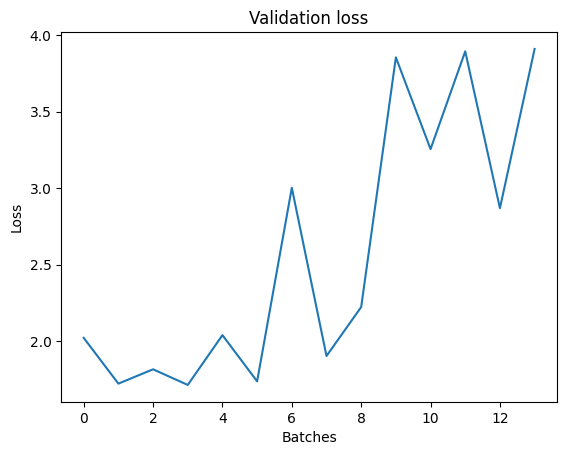

In [41]:
gptTrainer.train(1)

In [42]:
print(gptTrainer.model.my_generate('Что такое питон?'))

Что такое питон? Сгенерируй описание следующего текста, оцени наличие этнического конфликта, наличие позитивного взаимодействия этничностей, мнение о абхаз в тексте, является ли этничность 'абхаз' положительное, этнический конфликт отсутствует.
Текст: А если я не хочу, то мне не надо?
Описание: этот текст является негативным, в текст не является опасной
Задание: если вы не хотите,то не нужно. А вот если вас не хотят - то надо быть жертвой.


In [43]:
GPTparams = {
    'cut_data': [True, False],
    'batch_size': [8, 16, 32, 64],
    'lr': [1e-5, 1e-6, 1e-4, 1e-3],
    'ngrams': [0, 1, 2, 3, 4]
}

In [44]:
# gptTrainer.choose_model(GPTparams)